In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 | packaged by conda-forge | (main, Mar  3 2025, 20:43:55) [GCC 13.3.0].


In [2]:
import pandas as pd
df = pd.read_parquet('df.parquet')

In [3]:
horizon_len = 30
patch_len = 32
patch_num = 10
batch_size = 32
hidden_size = 128
channels = ['Close', 'High','Low',	'Open',	'Volume']

In [4]:
def get_model(load_weights: bool = False, horizon_len: int = 7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=horizon_len,
      num_layers=50,
      use_positional_embedding=False,
      context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
      input_patch_len=patch_len
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

In [5]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
#n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10
n_assets = len(asset_names)
# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [10]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (4606, 5, 320, 30), y: (4606, 5, 30, 30)


In [11]:
n_samples

4430

In [54]:
split_ix = int(n_samples * 0.975)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:4318
Test range: 4349:4429


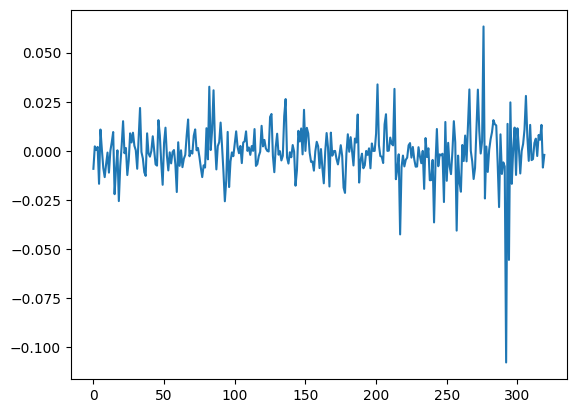

In [16]:
plt.plot(X[1, 1, :, 1])

In [17]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [ 0.00036889  0.00036662  0.00036826  0.00036795 -0.00021277], std: [0.01780644 0.01517264 0.01684082 0.01762673 0.34203538]


In [18]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [19]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [20]:
device = 'cuda'

In [ ]:
sfm_model, a, b = get_model(load_weights=True)
sfm_model.to('cuda')

In [38]:

from torch import dropout


class DeepNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.1, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        
     
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        
        self.embedding_layer_2 = nn.Linear(n_assets*channels, n_assets*32, bias=True)
        self.embedding_layer_1 = nn.Linear(n_assets*channels, n_assets*32, bias=True)
        # 参数
        d_model = n_assets*32  # 隐藏维度
        nhead = 4      # 注意力头数
        num_encoder_layers = 2  # 编码器层数
        num_decoder_layers = 2  # 解码器层数
        dim_feedforward = 2048  # 前馈层中间维度
        dropout = 0.2
        self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(d_model//n_assets * lookback, 1, bias=True)
        self.dense_layer_2 = torch.nn.Linear(horizon_len*32, 1, bias=True)
        
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=0.5)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, channels, lookback, n_assets = x.shape
        x = x.permute(0, 1, 3, 2)
        x = x.reshape(n_samples, channels*n_assets, lookback)
        m_list = [] 
        
        for i in range(n_samples):
            m = x[i, :,:]
            input_padding = torch.zeros_like(m).to(device)
            freq = torch.tensor([0], dtype=torch.long).to(device)
            with torch.no_grad():
                m = sfm_model(m, input_padding, freq) # B, patch_num, 128, 10 (mean +  9 quantiles)
            #m = sfm_model(m, input_padding, freq)
            m = m[:,:,:,0] # B, patch_num, 128
            m = m[:,-1,:] # B, 1, 128 last prediction
            m_list.append(m)
        m = torch.stack(m_list, dim=0) # B, channels*n_assets, 128
        m = m[:,:,0:horizon_len]
        m = m.permute(0,2,1) # B, horizon_len, channels*n_assets
        m = self.embedding_layer_1(m) # B, horizon_len, n_assets*32
    
        x = x.permute(0, 2, 1) # B, lookback, n_assets*channels
        x = self.embedding_layer_2(x) # B, lookback, n_assets*32
        x = self.encoder(x)
        x = self.decoder(m, x) # B, horizon_len, n_assets*32
        x = x.permute(0, 2, 1)
        x = x.reshape(n_samples, n_assets, -1)
        
        
        x = self.dropout_layer(x)
        x = self.dense_layer_2(x)
        x = x.squeeze(-1)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [39]:
network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)


In [ ]:
network

In [41]:
network_to_train = network.train() 

In [42]:
#loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
loss = MeanReturns()

In [43]:
#获得时间 作为文件名
import datetime
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = Run(network_to_train,
          loss,
          dataloader_train,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device
          )

#

In [ ]:
history = run.launch(2)

Epoch 2:  46%|████▌     | 62/135 [04:29<05:23,  4.43s/it, loss=-0.00099]

In [45]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       103
                    OneOverN       -1       103
                    network         0       103
                                    1       103
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       0.001
                    OneOverN       -1      -0.000
                    network         0      -0.001
                                    1      -0.001
Name: value, dtype: float32


<Axes: xlabel='epoch'>

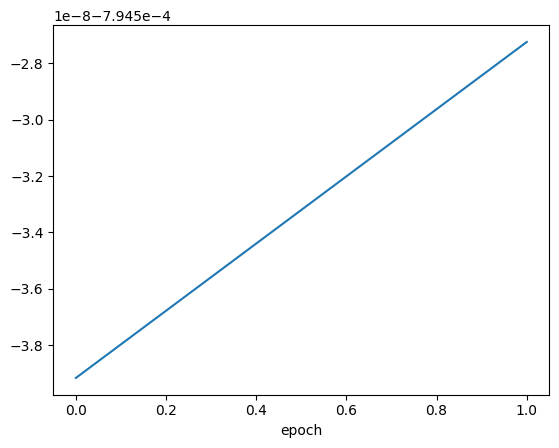

In [46]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [47]:
network = network.eval()

In [48]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    'network': network
}

In [49]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [50]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

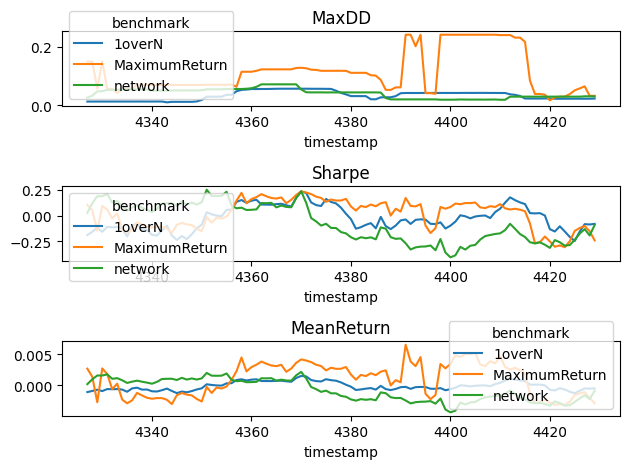

In [51]:
plot_metrics(metrics_table)

In [52]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

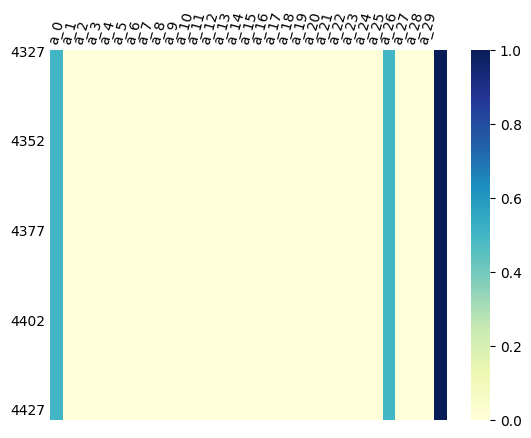

In [53]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)